In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [ ]:
# Initialize Firebase
cred = credentials.Certificate('/content/drive/MyDrive/Predictions/financiaflutter-firebase-adminsdk-ajaw7-f515e50a59.json')
firebase_admin.initialize_app(cred)

In [ ]:
crypto_currency = 'USDC'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = yf.download('USDC-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


Prepare Data

In [ ]:
print(data.head())

               Open     High      Low    Close  Adj Close   Volume
Date                                                              
2018-10-08  1.00410  1.00768  1.00190  1.00221    1.00221   382900
2018-10-09  1.00427  1.00833  1.00003  1.00686    1.00686   108803
2018-10-10  1.00494  1.01908  1.00397  1.00962    1.00962   711783
2018-10-11  1.00994  1.03123  1.00173  1.00978    1.00978  4177290
2018-10-12  1.00861  1.01871  1.00114  1.01272    1.01272  1322240


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scalar= MinMaxScaler(feature_range=(0,1))
scaled_data =scalar.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
prediction_days = 60
future_day = 10

x_train, y_train=[], []

In [ ]:
for x in range(prediction_days, len(scaled_data)-future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Create Neural Network

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
53/53 [==============================] - 17s 134ms/step - loss: 0.0182
Epoch 2/25
53/53 [==============================] - 5s 95ms/step - loss: 0.0050
Epoch 3/25
53/53 [==============================] - 5s 100ms/step - loss: 0.0047
Epoch 4/25
53/53 [==============================] - 7s 128ms/step - loss: 0.0044
Epoch 5/25
53/53 [==============================] - 5s 97ms/step - loss: 0.0044
Epoch 6/25
53/53 [==============================] - 7s 133ms/step - loss: 0.0045
Epoch 7/25
53/53 [==============================] - 5s 95ms/step - loss: 0.0044
Epoch 8/25
53/53 [==============================] - 5s 97ms/step - loss: 0.0043
Epoch 9/25
53/53 [==============================] - 7s 131ms/step - loss: 0.0041
Epoch 10/25
53/53 [==============================] - 5s 95ms/step - loss: 0.0043
Epoch 11/25
53/53 [==============================] - 7s 131ms/step - loss: 0.0041
Epoch 12/25
53/53 [==============================] - 6s 110ms/step - loss: 0.0041
Epoch 13/25
53/53 [==========

Testing the model

In [ ]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download('USDC-USD', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

[*********************100%***********************]  1 of 1 completed


In [ ]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.fit_transform(model_inputs)

In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
prediction_prices = model.predict(x_test)
prediction_prices = scalar.inverse_transform(prediction_prices)

41/41 [==============================] - 2s 28ms/step


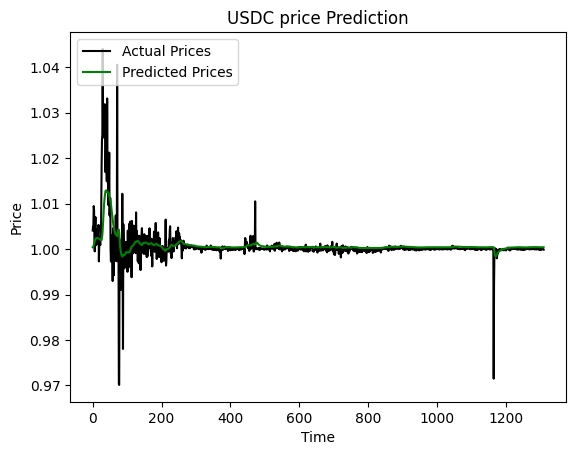

In [ ]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title('USDC price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()

# Predict next day

In [ ]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)


In [ ]:
real_data.shape

(1, 59)

In [ ]:
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1], 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scalar.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 1s/step
[[1.0004038]]


In [ ]:
# Save the prediction value to Firebase Firestore
db = firestore.client()
doc_ref = db.collection('predictioncrypto').document(crypto_currency)
doc_ref.set({
    'prediction': float(prediction[0][0])
})

update_time {
  seconds: 1691398284
  nanos: 333910000
}